## BERT for sequence classification


In [1]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast, \
     DataCollatorWithPadding, pipeline
from datasets import load_metric, Dataset
import numpy as np

In [19]:
import urllib3

In [21]:
http = urllib3.PoolManager()

In [25]:
snips_file

'listen O\r\nto O\r\nwestbam B-artist\r\nalumb O\r\nallergic B-album\r\non O\r\ngoogle B-service\r\nmusic I-service\r\nPlayMusic\r\n\r\nadd O\r\nstep B-entity_name\r\nto I-entity_name\r\nme I-entity_name\r\nto O\r\nthe O\r\n50 B-playlist\r\nclásicos I-playlist\r\nplaylist O\r\nAddToPlaylist\r\n\r\ni O\r\ngive O\r\nthis O\r\ncurrent B-object_select\r\ntextbook B-object_type\r\na O\r\nrating O\r\nvalue O\r\nof O\r\n1 B-rating_value\r\nand O\r\na O\r\nbest O\r\nrating O\r\nof O\r\n6 B-best_rating\r\nRateBook\r\n\r\nplay O\r\nthe O\r\nsong B-music_item\r\nlittle B-track\r\nrobin I-track\r\nredbreast I-track\r\nPlayMusic\r\n\r\nplease O\r\nadd O\r\niris B-artist\r\ndement I-artist\r\nto O\r\nmy B-playlist_owner\r\nplaylist O\r\nthis B-playlist\r\nis I-playlist\r\nselena I-playlist\r\nAddToPlaylist\r\n\r\nadd O\r\nslimm B-artist\r\ncutta I-artist\r\ncalhoun I-artist\r\nto O\r\nmy B-playlist_owner\r\nthis B-playlist\r\nis I-playlist\r\nprince I-playlist\r\nplaylist O\r\nAddToPlaylist\r\n\r\ni

In [22]:
snips_file = http.request('GET', 'https://raw.githubusercontent.com/sinanuozdemir/oreilly-hands-on-transformers/main/data/snips.train.txt').data.decode('utf-8')

snips_rows = snips_file.readlines()

snips_rows[:20]

AttributeError: 'str' object has no attribute 'readlines'

In [3]:
# This code segment parses the snips dataset into a more manageable format

utterances = []
tokenized_utterances = []
labels_for_tokens = []
sequence_labels = []

utterance, tokenized_utterance, label_for_utterances = '', [], []
for snip_row in snips_rows:
    if len(snip_row) == 2:  # skip over rows with no data
        continue
    if ' ' not in snip_row.decode():  # we've hit a sequence label
        sequence_labels.append(snip_row.decode().strip())
        utterances.append(utterance.strip())
        tokenized_utterances.append(tokenized_utterance)
        labels_for_tokens.append(label_for_utterances)
        utterance = ''
        tokenized_utterance = []
        label_for_utterances = []
        continue
    token, token_label = snip_row.decode().split(' ')
    token_label = token_label.strip()
    utterance += f'{token} '
    tokenized_utterance.append(token)
    label_for_utterances.append(token_label)
    

In [4]:
len(labels_for_tokens), len(tokenized_utterances), len(utterances), len(sequence_labels)

(13084, 13084, 13084, 13084)

In [6]:
utterances[0], sequence_labels[0]

('listen to westbam alumb allergic on google music', 'PlayMusic')

In [207]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

loading file https://huggingface.co/distilbert-base-cased/resolve/main/vocab.txt from cache at /Users/sinanozdemir/.cache/huggingface/transformers/ba377304984dc63e3ede0e23a938bbbf04d5c3835b66d5bb48343aecca188429.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/distilbert-base-cased/resolve/main/tokenizer.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/acb5c2138c1f8c84f074b86dafce3631667fccd6efcb1a7ea1320cf75c386a36.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
loading file https://huggingface.co/distilbert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-cased/resolve/main/tokenizer_config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/81e970e5e6ec68be12da0f8f3b2f2469c78d579282299a2ea65b4b744171

In [208]:
unique_sequence_labels = list(set(sequence_labels))
unique_sequence_labels

['PlayMusic',
 'RateBook',
 'SearchScreeningEvent',
 'SearchCreativeWork',
 'BookRestaurant',
 'GetWeather',
 'AddToPlaylist']

In [209]:
sequence_labels = [unique_sequence_labels.index(l) for l in sequence_labels]

print(f'There are {len(unique_sequence_labels)} unique sequence labels')

There are 7 unique sequence labels


In [210]:
from functools import reduce

unique_token_labels = list(set(reduce(lambda x, y: x + y, labels_for_tokens)))
labels_for_tokens = [[unique_token_labels.index(_) for _ in l] for l in labels_for_tokens]

print(f'There are {len(unique_token_labels)} unique token labels')

There are 72 unique token labels


In [211]:
print(tokenized_utterances[0])
print(labels_for_tokens[0])
print([unique_token_labels[l] for l in labels_for_tokens[0]])
print(utterances[0])
print(sequence_labels[0])
print(unique_sequence_labels[sequence_labels[0]])

['listen', 'to', 'westbam', 'alumb', 'allergic', 'on', 'google', 'music']
[22, 22, 68, 22, 58, 22, 51, 4]
['O', 'O', 'B-artist', 'O', 'B-album', 'O', 'B-service', 'I-service']
listen to westbam alumb allergic on google music
0
PlayMusic


In [212]:
snips_dataset = Dataset.from_dict(
    dict(
        utterance=utterances, 
        label=sequence_labels,
        tokens=tokenized_utterances,
        token_labels=labels_for_tokens
    )
)
snips_dataset = snips_dataset.train_test_split(test_size=0.2)

In [213]:
snips_dataset['train'][0]

{'utterance': 'rate homicide: a year on the killing streets five stars',
 'label': 1,
 'tokens': ['rate',
  'homicide:',
  'a',
  'year',
  'on',
  'the',
  'killing',
  'streets',
  'five',
  'stars'],
 'token_labels': [22, 44, 13, 13, 13, 13, 13, 13, 53, 29]}

In [18]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):
    return tokenizer(examples["utterance"], truncation=True)

In [19]:
seq_clf_tokenized_snips = snips_dataset.map(preprocess_function, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3 [00:00<?, ?ba/s]

In [20]:
seq_clf_tokenized_snips['train'][0]

{'utterance': 'play a twenties song',
 'label': 0,
 'tokens': ['play', 'a', 'twenties', 'song'],
 'token_labels': [22, 22, 37, 7],
 'input_ids': [101, 1505, 170, 21708, 1461, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [22]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Data Collator will pad data so that all examples are the same input length.
#  Attention mask is how we ignore attention scores for padding tokens

In [69]:
sequence_clf_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=len(unique_sequence_labels),
)

# set an index -> label dictionary
sequence_clf_model.config.id2label = {i: l for i, l in enumerate(unique_sequence_labels)}

loading configuration file https://huggingface.co/distilbert-base-cased/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/ebe1ea24d11aa664488b8de5b21e33989008ca78f207d4e30ec6350b693f073f.302bfd1b5e031cc1b17796e0b6e5b242ba2045d31d00f97589e12b458ebff27a
Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_w

In [70]:
sequence_clf_model.config.id2label[0]

'PlayMusic'

In [24]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):  # custom method to take in logits and calculate accuracy of the eval set
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [25]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./snips_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    
    # some deep learning parameters that the Trainer is able to take in
    warmup_steps=len(seq_clf_tokenized_snips['train']) // 5,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,
    
    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=seq_clf_tokenized_snips['train'],
    eval_dataset=seq_clf_tokenized_snips['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [26]:
# Get initial metrics
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, tokens, utterance.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 1.9550352096557617,
 'eval_accuracy': 0.09973251815055408,
 'eval_runtime': 64.0129,
 'eval_samples_per_second': 40.882,
 'eval_steps_per_second': 1.281}

In [27]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, tokens, utterance.
***** Running training *****
  Num examples = 10467
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 656


Epoch,Training Loss,Validation Loss,Accuracy
1,0.125300,0.159812,0.971341
2,0.009100,0.051554,0.987008


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, tokens, utterance.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_clf/results/checkpoint-328
Configuration saved in ./snips_clf/results/checkpoint-328/config.json
Model weights saved in ./snips_clf/results/checkpoint-328/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, tokens, utterance.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_clf/results/checkpoint-656
Configuration saved in ./snips_clf/results/checkpoint-656/config.json
Model weights saved in ./snips_clf/results/checkpoint-656/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface

TrainOutput(global_step=656, training_loss=0.6844381606277283, metrics={'train_runtime': 1376.1424, 'train_samples_per_second': 15.212, 'train_steps_per_second': 0.477, 'total_flos': 131576695874496.0, 'train_loss': 0.6844381606277283, 'epoch': 2.0})

In [28]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, tokens, utterance.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 0.05155394226312637,
 'eval_accuracy': 0.9870080244554834,
 'eval_runtime': 51.0558,
 'eval_samples_per_second': 51.258,
 'eval_steps_per_second': 1.606,
 'epoch': 2.0}

In [60]:
pipe = pipeline("text-classification", sequence_clf_model, tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

[{'label': 'AddToPlaylist', 'score': 0.9956121444702148}]

In [30]:
trainer.save_model()

Saving model checkpoint to ./snips_clf/results
Configuration saved in ./snips_clf/results/config.json
Model weights saved in ./snips_clf/results/pytorch_model.bin


In [61]:
pipe = pipeline("text-classification", "./snips_clf/results", tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

loading configuration file ./snips_clf/results/config.json
Model config DistilBertConfig {
  "_name_or_path": "./snips_clf/results",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "PlayMusic",
    "1": "RateBook",
    "2": "SearchScreeningEvent",
    "3": "SearchCreativeWork",
    "4": "BookRestaurant",
    "5": "GetWeather",
    "6": "AddToPlaylist"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype":

[{'label': 'AddToPlaylist', 'score': 0.9956121444702148}]

In [126]:
frozen_sequence_clf_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=len(unique_sequence_labels),
)

loading configuration file https://huggingface.co/distilbert-base-cased/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/ebe1ea24d11aa664488b8de5b21e33989008ca78f207d4e30ec6350b693f073f.302bfd1b5e031cc1b17796e0b6e5b242ba2045d31d00f97589e12b458ebff27a
Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_w

In [127]:
for param in frozen_sequence_clf_model.distilbert.parameters():
    param.requires_grad = False

In [128]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./snips_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    
    # some deep learning parameters that the Trainer is able to take in
    warmup_steps=len(seq_clf_tokenized_snips['train']) // 5,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,
    
    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=frozen_sequence_clf_model,
    args=training_args,
    train_dataset=seq_clf_tokenized_snips['train'],
    eval_dataset=seq_clf_tokenized_snips['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [129]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, tokens, utterance.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 1.9511256217956543,
 'eval_accuracy': 0.13870844478410393,
 'eval_runtime': 33.0914,
 'eval_samples_per_second': 79.084,
 'eval_steps_per_second': 2.478}

In [130]:
trainer.train()  # ~23min -> ~6min on my laptop with all of distilbert frozen with a worse loss/accuracy

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, tokens, utterance.
***** Running training *****
  Num examples = 10467
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 656


Epoch,Training Loss,Validation Loss,Accuracy
1,1.894000,1.889941,0.356133
2,1.652300,1.679589,0.872755


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, tokens, utterance.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_clf/results/checkpoint-328
Configuration saved in ./snips_clf/results/checkpoint-328/config.json
Model weights saved in ./snips_clf/results/checkpoint-328/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, tokens, utterance.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_clf/results/checkpoint-656
Configuration saved in ./snips_clf/results/checkpoint-656/config.json
Model weights saved in ./snips_clf/results/checkpoint-656/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface

TrainOutput(global_step=656, training_loss=1.8726866072634372, metrics={'train_runtime': 377.717, 'train_samples_per_second': 55.422, 'train_steps_per_second': 1.737, 'total_flos': 131576695874496.0, 'train_loss': 1.8726866072634372, 'epoch': 2.0})

In [131]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_labels, tokens, utterance.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 1.679589033126831,
 'eval_accuracy': 0.8727550630492931,
 'eval_runtime': 32.8797,
 'eval_samples_per_second': 79.593,
 'eval_steps_per_second': 2.494,
 'epoch': 2.0}

## BONUS MATERIAL

## BERT for token classification

In [74]:
from transformers import DataCollatorForTokenClassification, DistilBertForTokenClassification, \
                         DistilBertTokenizerFast, pipeline

In [76]:
# using a cased tokenizer because I think case will matter
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

loading file https://huggingface.co/distilbert-base-cased/resolve/main/vocab.txt from cache at /Users/sinanozdemir/.cache/huggingface/transformers/ba377304984dc63e3ede0e23a938bbbf04d5c3835b66d5bb48343aecca188429.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/distilbert-base-cased/resolve/main/tokenizer.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/acb5c2138c1f8c84f074b86dafce3631667fccd6efcb1a7ea1320cf75c386a36.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
loading file https://huggingface.co/distilbert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-cased/resolve/main/tokenizer_config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/81e970e5e6ec68be12da0f8f3b2f2469c78d579282299a2ea65b4b744171

In [77]:
snips_dataset['train'][0]

{'utterance': 'play a twenties song',
 'label': 0,
 'tokens': ['play', 'a', 'twenties', 'song'],
 'token_labels': [22, 22, 37, 7]}

In [90]:
# The given "token_labels" may not match up with the BERT wordpiece tokenization so
#  this function will map them to the tokenization that BERT uses
#  -100 is a reserved for labels where we do not want to calculate losses so BERT doesn't waste time
#  trying to predict tokens like CLS or SEP

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"token_labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:  # Set the special tokens to -100.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)  # CLS and SEP are labeled as -100
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [172]:
snips_dataset['train'][0]

{'utterance': 'play a twenties song',
 'label': 0,
 'tokens': ['play', 'a', 'twenties', 'song'],
 'token_labels': [22, 22, 37, 7]}

In [173]:
# map our dataset from sequence classification to be for token classification
tok_clf_tokenized_snips = snips_dataset.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [174]:
tok_clf_tokenized_snips['train'][0]

{'utterance': 'play a twenties song',
 'label': 0,
 'tokens': ['play', 'a', 'twenties', 'song'],
 'token_labels': [22, 22, 37, 7],
 'input_ids': [101, 1505, 170, 21708, 1461, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1],
 'labels': [-100, 22, 22, 37, 7, -100]}

In [175]:
tok_clf_tokenized_snips['train'] = tok_clf_tokenized_snips['train'].remove_columns(
    ['utterance', 'label', 'tokens', 'token_labels']
)

tok_clf_tokenized_snips['test'] = tok_clf_tokenized_snips['test'].remove_columns(
    ['utterance', 'label', 'tokens', 'token_labels']
)

tok_clf_tokenized_snips

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10467
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2617
    })
})

In [96]:
tok_data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [97]:
tok_clf_model = DistilBertForTokenClassification.from_pretrained(
    'distilbert-base-cased', num_labels=len(unique_token_labels)
)

# Set our label dictionary
tok_clf_model.config.id2label = {i: l for i, l in enumerate(unique_token_labels)}

loading configuration file https://huggingface.co/distilbert-base-cased/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/ebe1ea24d11aa664488b8de5b21e33989008ca78f207d4e30ec6350b693f073f.302bfd1b5e031cc1b17796e0b6e5b242ba2045d31d00f97589e12b458ebff27a
Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
 

In [178]:
tok_clf_model.config.id2label[0], tok_clf_model.config.id2label[1]

('B-country', 'B-timeRange')

In [98]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./snips_tok_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
        
    logging_steps=10,
    log_level='info',
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=tok_clf_model,
    args=training_args,
    train_dataset=tok_clf_tokenized_snips['train'],
    eval_dataset=tok_clf_tokenized_snips['test'],
    data_collator=tok_data_collator
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [99]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 4.45733642578125,
 'eval_runtime': 40.4286,
 'eval_samples_per_second': 64.731,
 'eval_steps_per_second': 2.028}

In [100]:
trainer.train()

***** Running training *****
  Num examples = 10467
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 656


Epoch,Training Loss,Validation Loss
1,0.204000,0.172545
2,0.099500,0.130660


***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_tok_clf/results/checkpoint-328
Configuration saved in ./snips_tok_clf/results/checkpoint-328/config.json
Model weights saved in ./snips_tok_clf/results/checkpoint-328/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_tok_clf/results/checkpoint-656
Configuration saved in ./snips_tok_clf/results/checkpoint-656/config.json
Model weights saved in ./snips_tok_clf/results/checkpoint-656/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./snips_tok_clf/results/checkpoint-656 (score: 0.13066013157367706).


TrainOutput(global_step=656, training_loss=0.397148780070427, metrics={'train_runtime': 1851.7923, 'train_samples_per_second': 11.305, 'train_steps_per_second': 0.354, 'total_flos': 129927264993792.0, 'train_loss': 0.397148780070427, 'epoch': 2.0})

In [101]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 0.13066013157367706,
 'eval_runtime': 34.3515,
 'eval_samples_per_second': 76.183,
 'eval_steps_per_second': 2.387,
 'epoch': 2.0}

In [102]:
pipe = pipeline("token-classification", tok_clf_model, tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

[{'entity': 'B-entity_name',
  'score': 0.887767,
  'index': 3,
  'word': 'Here',
  'start': 11,
  'end': 15},
 {'entity': 'I-entity_name',
  'score': 0.88551474,
  'index': 4,
  'word': 'We',
  'start': 16,
  'end': 18},
 {'entity': 'I-entity_name',
  'score': 0.9170048,
  'index': 5,
  'word': 'Go',
  'start': 19,
  'end': 21},
 {'entity': 'B-artist',
  'score': 0.93062943,
  'index': 7,
  'word': 'Di',
  'start': 25,
  'end': 27},
 {'entity': 'I-artist',
  'score': 0.94451386,
  'index': 8,
  'word': '##sp',
  'start': 27,
  'end': 29},
 {'entity': 'I-artist',
  'score': 0.78699875,
  'index': 9,
  'word': '##atch',
  'start': 29,
  'end': 33},
 {'entity': 'B-playlist_owner',
  'score': 0.9935272,
  'index': 11,
  'word': 'my',
  'start': 37,
  'end': 39},
 {'entity': 'B-playlist',
  'score': 0.994918,
  'index': 12,
  'word': 'road',
  'start': 40,
  'end': 44},
 {'entity': 'I-playlist',
  'score': 0.9942649,
  'index': 13,
  'word': 'trip',
  'start': 45,
  'end': 49}]

In [181]:
pipe = pipeline("token-classification", tok_clf_model, tokenizer=tokenizer)
pipe('Rate the doog food 5 out of 5')

[{'entity': 'B-object_name',
  'score': 0.94716674,
  'index': 2,
  'word': 'the',
  'start': 5,
  'end': 8},
 {'entity': 'I-object_name',
  'score': 0.95756745,
  'index': 3,
  'word': 'do',
  'start': 9,
  'end': 11},
 {'entity': 'I-object_name',
  'score': 0.9812471,
  'index': 4,
  'word': '##og',
  'start': 11,
  'end': 13},
 {'entity': 'I-object_name',
  'score': 0.97237736,
  'index': 5,
  'word': 'food',
  'start': 14,
  'end': 18},
 {'entity': 'B-rating_value',
  'score': 0.9964361,
  'index': 6,
  'word': '5',
  'start': 19,
  'end': 20},
 {'entity': 'B-best_rating',
  'score': 0.97492224,
  'index': 9,
  'word': '5',
  'start': 28,
  'end': 29}]

## BERT for question/answering

In [128]:
from transformers import BertTokenizerFast, BertForQuestionAnswering, pipeline, \
                         DataCollatorWithPadding, TrainingArguments, Trainer, \
                         AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

In [52]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased', return_token_type_ids=True)

qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased')

loading file https://huggingface.co/bert-large-uncased/resolve/main/vocab.txt from cache at /Users/sinanozdemir/.cache/huggingface/transformers/e12f02d630da91a0982ce6db1ad595231d155a2b725ab106971898276d842ecc.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-large-uncased/resolve/main/tokenizer.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/475d46024228961ca8770cead39e1079f135fd2441d14cf216727ffac8d41d78.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-large-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-large-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-large-uncased/resolve/main/tokenizer_config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/300ecd79785b4602752c0085f8a89c3f0232ef367eda291c79a5600f3778b677.20430bd8e1

In [118]:
qa_df = pd.read_csv('../data/qa.csv')

qa_df.shape

(29989, 5)

In [116]:
qa_df.head()

,question,context,start_positions,end_positions,answer
0,What sare the benifts of the blood brain barrir?,Another approach to brain function is to exami...,56,60,isolated from the bloodstream
1,What is surrounded by cerebrospinal fluid?,Another approach to brain function is to exami...,16,16,brain
2,What does the skull protect?,Another approach to brain function is to exami...,11,11,brain
3,What has been injected into rats to produce pr...,Another approach to brain function is to exami...,153,153,chemicals
4,What can cause issues with how the brain works?,Another approach to brain function is to exami...,93,94,brain damage


In [117]:
qa_df.iloc[0]

question            What sare the benifts of the blood brain barrir?
context            Another approach to brain function is to exami...
start_positions                                                   56
end_positions                                                     60
answer                                 isolated from the bloodstream
Name: 0, dtype: object

In [124]:
# index 56, 57, 58, 59, and 60 including question while encoding
bert_tokenizer.decode(bert_tokenizer.encode(qa_df.iloc[0].question, qa_df.iloc[0].context)[56:61])

'isolated from the bloodstream'

In [56]:
# only grab 4,000 examples
qa_dataset = Dataset.from_pandas(qa_df.sample(4000, random_state=42))

# Dataset has a built in train test split method
qa_dataset = qa_dataset.train_test_split(test_size=0.2)

In [57]:
# standard preprocessing here with truncation on to truncate longer text
def preprocess(data):
    return bert_tokenizer(data['question'], data['context'], truncation=True)

qa_dataset = qa_dataset.map(preprocess, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [58]:
# freeze all but the last 2 encoder layers in BERT to speed up training
for name, param in qa_bert.bert.named_parameters():
    if 'encoder.layer.22' in name:
        break
    param.requires_grad = False  # disable training in BERT

In [59]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [20]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./qa/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./qa/logs',
    save_strategy='epoch',
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=qa_bert,
    args=training_args,
    train_dataset=qa_dataset['train'],
    eval_dataset=qa_dataset['test'],
    data_collator=data_collator
)

# Get initial metrics
trainer.evaluate()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, context, answer, question.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 32


{'eval_loss': 6.270374774932861,
 'eval_runtime': 1428.4792,
 'eval_samples_per_second': 0.56,
 'eval_steps_per_second': 0.018}

In [21]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, context, answer, question.
***** Running training *****
  Num examples = 3200
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 400


Epoch,Training Loss,Validation Loss
1,4.314100,4.248008
2,4.009000,4.084617


The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, context, answer, question.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 32
Saving model checkpoint to ./qa/results/checkpoint-100
Configuration saved in ./qa/results/checkpoint-100/config.json
Model weights saved in ./qa/results/checkpoint-100/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, context, answer, question.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 32
Saving model checkpoint to ./qa/results/checkpoint-200
Configuration saved in ./qa/results/checkpoint-200/config.json
Model weights saved in ./qa/results/checkpoint-200/pytorch_model.bin


KeyboardInterrupt: 

In [ ]:
# Q/A models are very large and take a long time to fine-tune

In [22]:
trainer.save_model()

Saving model checkpoint to ./qa/results
Configuration saved in ./qa/results/config.json
Model weights saved in ./qa/results/pytorch_model.bin


In [101]:
pipe = pipeline("question-answering", './qa/results', tokenizer=bert_tokenizer)

loading configuration file ./qa/results/config.json
Model config BertConfig {
  "_name_or_path": "./qa/results",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file ./qa/results/config.json
Model config BertConfig {
  "_name_or_path": "./qa/results",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_che

In [92]:
pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.13000917434692383, 'start': 15, 'end': 25, 'answer': 'California'}

In [93]:
princeton = """In 1675, a Quaker missionary from England, encouraged by New Jersey proprietors John Lord 
              "Berkeley and Sir George Carteret, arrived to establish a settlement in this area near the 
              "Delaware River, which was inhabited by the Lenni-Lenape Indians. The Keith survey of 1685 
              "established the western boundary of Middlesex and Somerset Counties and later, the Township 
              "of Princeton. Today Keith's Line is recognized as Province Line Road. With the laying of the 
              "cornerstone for Nassau Hall in 1754, Princeton began its development as a location for 
              "quality education. Nassau Hall was named for William III, Prince of Orange-Nassau. This simple stone 
              "edifice was one of the largest public buildings in the colonies and became a model for many other 
              "structures in New Jersey and Pennsylvania."""

pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.005417873617261648, 'start': 281, 'end': 286, 'answer': 'Keith'}

In [107]:
PERSON = 'Sinan Ozdemir'

# Note this is NOT an efficient way to search on google. This is done simply for education purposes
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}').text).get_text()[:512]

pipe(f'Who is {PERSON}?', google_html)

{'score': 0.0028718607500195503,
 'start': 379,
 'end': 401,
 'answer': 'lecturer/mathematician'}

In [146]:
# From Huggingface: https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

squad_pipe = pipeline("question-answering", "bert-large-uncased-whole-word-masking-finetuned-squad")

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loa

In [147]:
squad_pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.9924464821815491, 'start': 15, 'end': 25, 'answer': 'California'}

In [148]:
squad_pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.31145334243774414,
 'start': 277,
 'end': 293,
 'answer': 'The Keith survey'}

In [154]:
# visualize logits
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

qa_input = large_tokenizer(  # tokenize our example
    "What survey led to the founding of Princeton?", princeton,
    return_tensors='pt'
)

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loa

In [155]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

output = large_qa_bert(**qa_input)  # pass the input through our QA model
output

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loa

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.7519, -3.6147, -8.6238, -8.5794, -8.7563, -8.1872, -8.1031, -8.2268,
         -7.5512, -9.8327, -5.7519, -6.2746, -4.7469, -7.9981, -6.5231, -6.2942,
         -6.9675, -8.3130, -7.0369, -8.2833, -6.1628, -8.1123, -5.4992, -5.6526,
         -6.2636, -8.3655, -5.3692, -7.8447, -8.8567, -6.3198, -8.5963, -5.9721,
         -7.6135, -7.3562, -8.2679, -8.3762, -6.8817, -7.8090, -7.5480, -7.4207,
         -7.2773, -8.2750, -7.7373, -7.5004, -7.8319, -7.9563, -7.1041, -5.7036,
         -7.5340, -8.4661, -8.3033, -7.9716, -7.2749, -8.5451, -8.1295, -7.2359,
         -8.6795, -8.9292, -7.6118, -8.6576, -6.9020, -5.7518,  6.3959,  5.9311,
         -1.0083, -4.0455,  1.1958, -4.5241, -2.6724, -4.6225, -3.4796, -5.6253,
         -7.3676, -5.4171, -7.9947, -5.3715, -5.9689, -8.1691, -6.2237, -7.7371,
         -4.7933, -5.0089, -6.9667, -5.7007, -3.2038, -4.9603, -4.6802,  1.7422,
         -7.9737, -6.3608, -5.4654, -7.9430, -7.3093, -7

In [156]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())

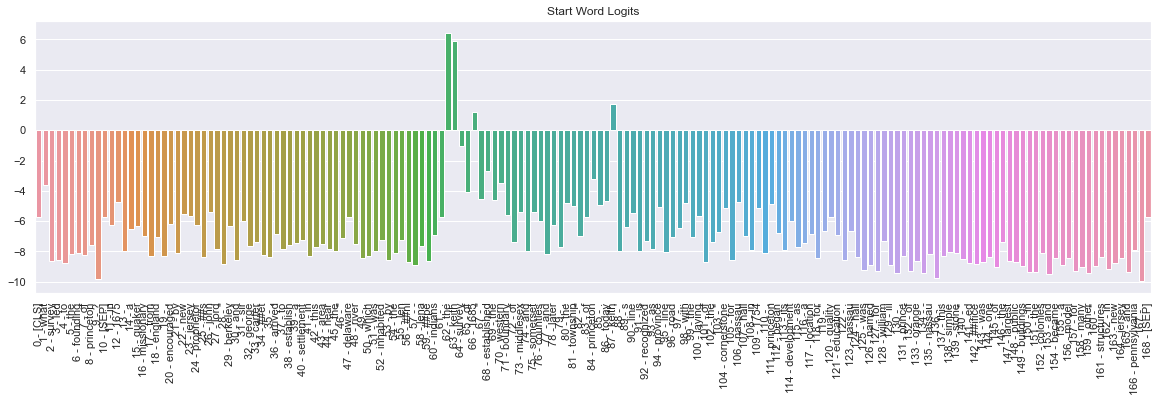

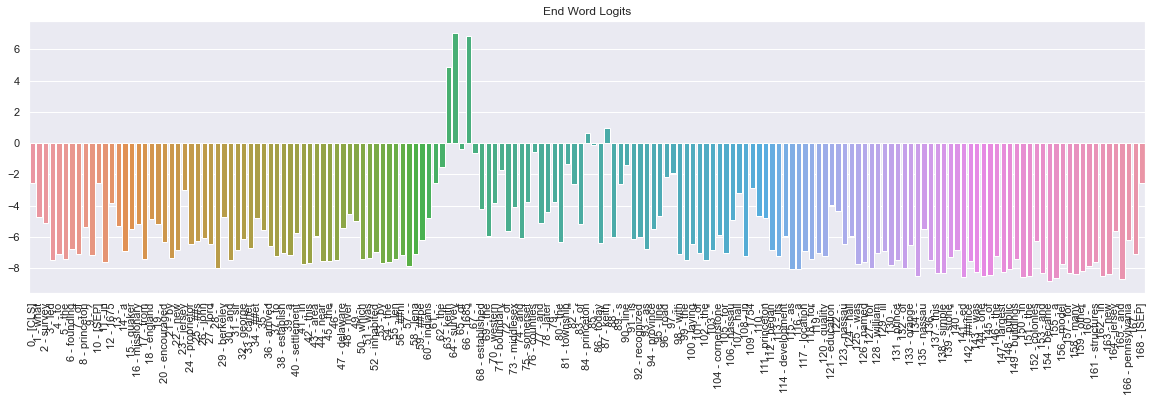

In [157]:
# Plot start and end logits for our fine-tuned model

sns.set(rc={"figure.figsize":(20, 5)}) 

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('Start Word Logits')

plt.show()

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('End Word Logits')

plt.show()